<a href="https://colab.research.google.com/github/Arashfd75/disaster_tweets/blob/main/tweet_disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB
Percentage of missing data in Train: keyword      0.807733
location    49.862205
dtype: float64
Percentage of missing data in Test: keyword      0.803213
location    51.204819
dtype: float64
keyword     7552
location    5080
dtype: int64
keyword       61
location    2533
dtype: int64
Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


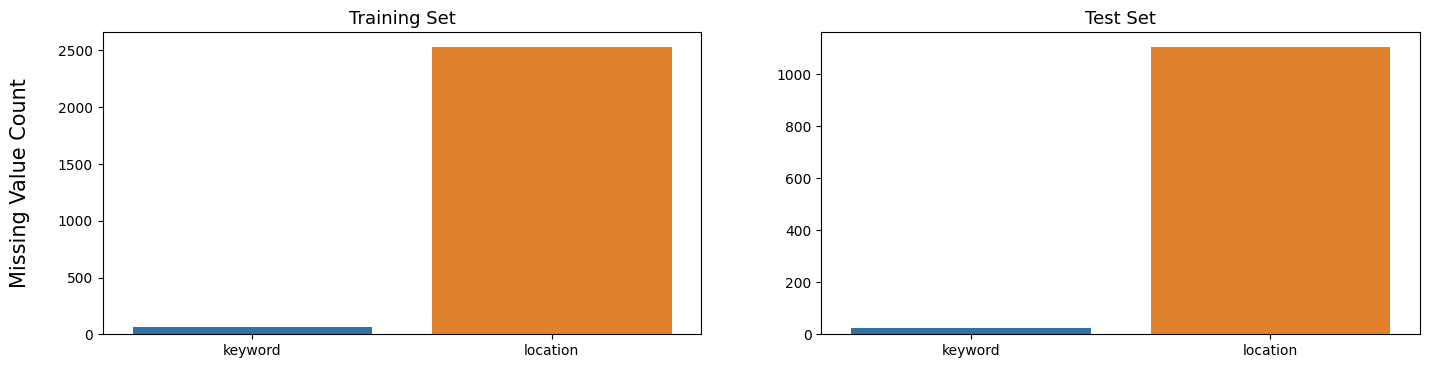

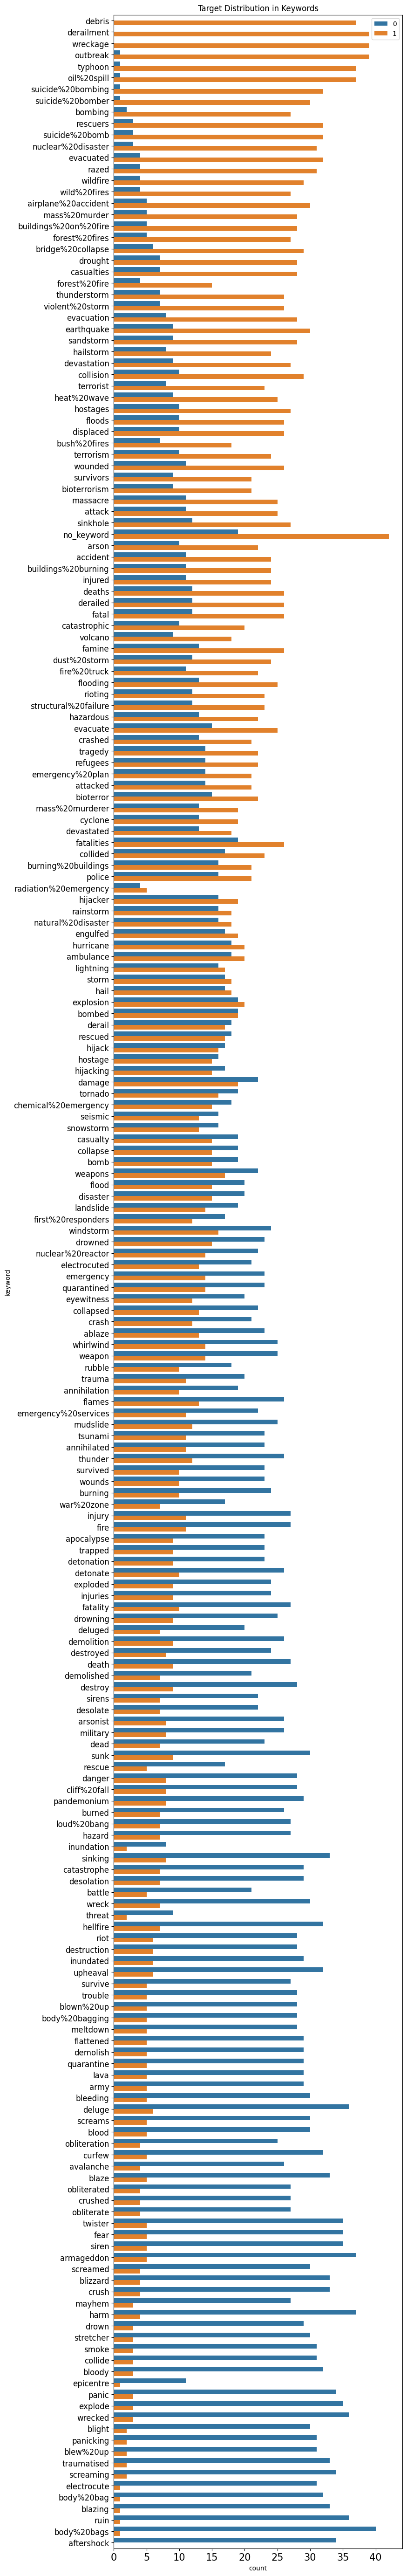

In [28]:

import gc
import re
import string
import operator
from collections import defaultdict
from collections import  Counter
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 1000
import matplotlib.pyplot as plt
import seaborn as sns
!pip3 install tokenization
!pip install pyspellchecker
from spellchecker import SpellChecker
import tokenization
from wordcloud import STOPWORDS
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
# import model

df_train = pd.read_csv('/content/drive/MyDrive/Kaggle/disaster_tweets/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('/content/drive/MyDrive/Kaggle/disaster_tweets/test.csv', dtype={'id': np.int16})
if __name__ == "__main__":
    print('Training Set Shape = {}'.format(df_train.shape))
    print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
    print('Test Set Shape = {}'.format(df_test.shape))
    print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
# import tokenization
# from wordcloud import STOPWORDS

# from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
# from sklearn.metrics import precision_score, recall_score, f1_score

# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow import keras
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x= df_train[missing_cols].isnull().sum().index, y= df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x= df_test[missing_cols].isnull().sum().index, y= df_test[missing_cols].isnull().sum().values, ax=axes[1])
axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)
print(f"Percentage of missing data in Train: {100 *  df_train[missing_cols].isna().sum() /  df_train[missing_cols].count()}" )
print(f"Percentage of missing data in Test: {100 *  df_test[missing_cols].isna().sum() /  df_test[missing_cols].count()}" )
# plt.show()
print(  df_train[missing_cols].count())
print( df_train[missing_cols].isna().sum())

for df in [ df_train,  df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')


print(f'Number of unique values in keyword = { df_train["keyword"].nunique()} (Training) - { df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = { df_train["location"].nunique()} (Training) - { df_test["location"].nunique()} (Test)')


df_train['target_mean'] =  df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y= df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue= df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [2]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

#unique_words
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

#stopwords_count # what about non_stopwords_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#urls
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_train['url_count']


#mean word length # should we consider stopwords??
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

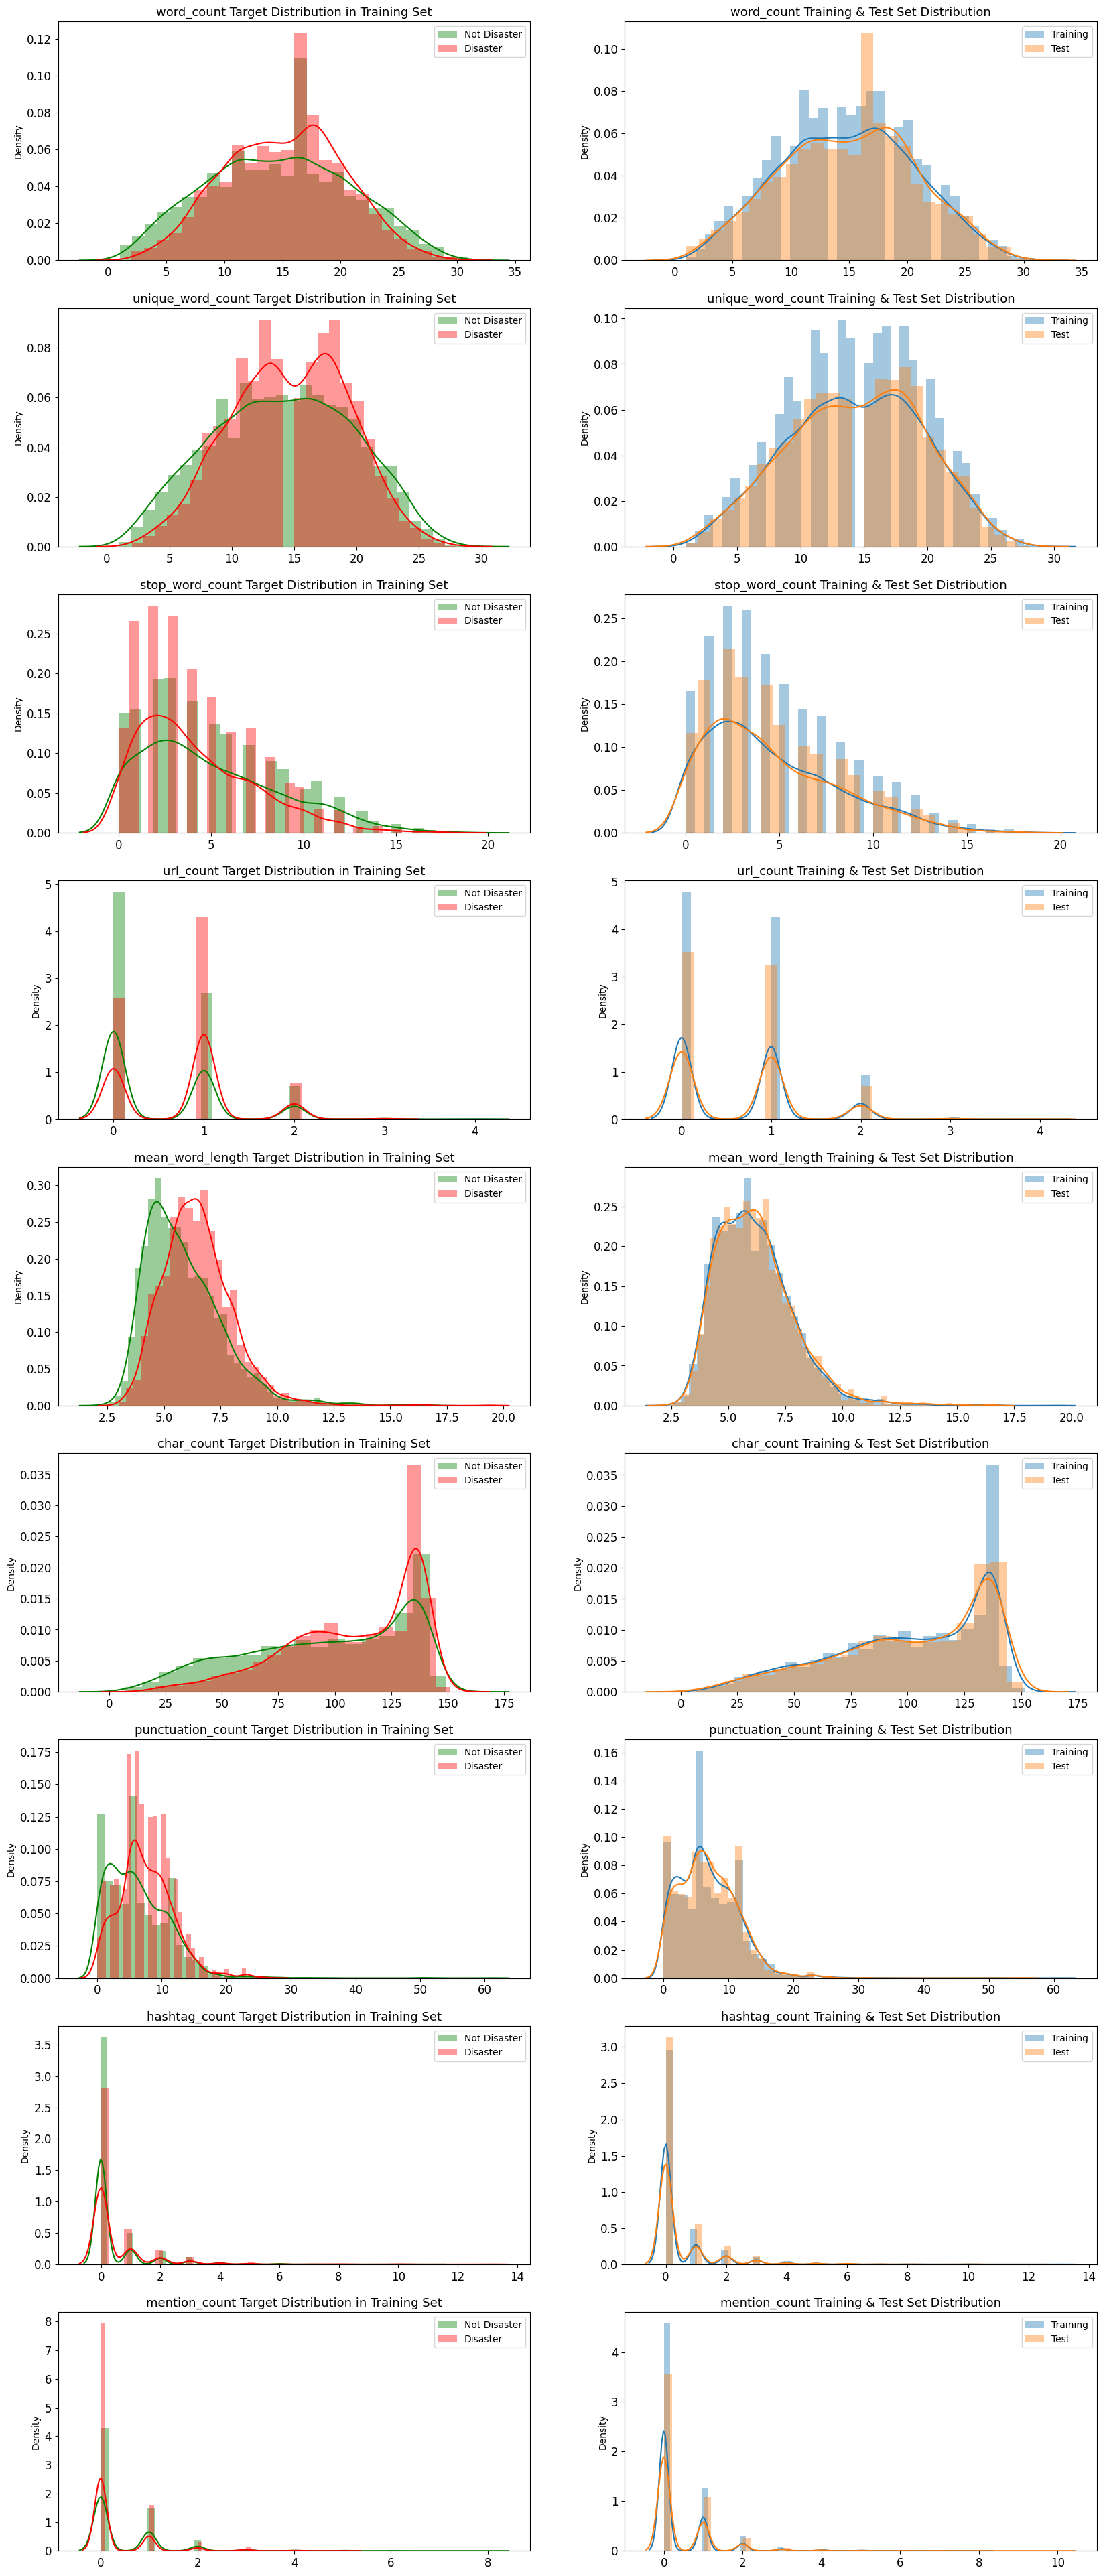

In [3]:

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

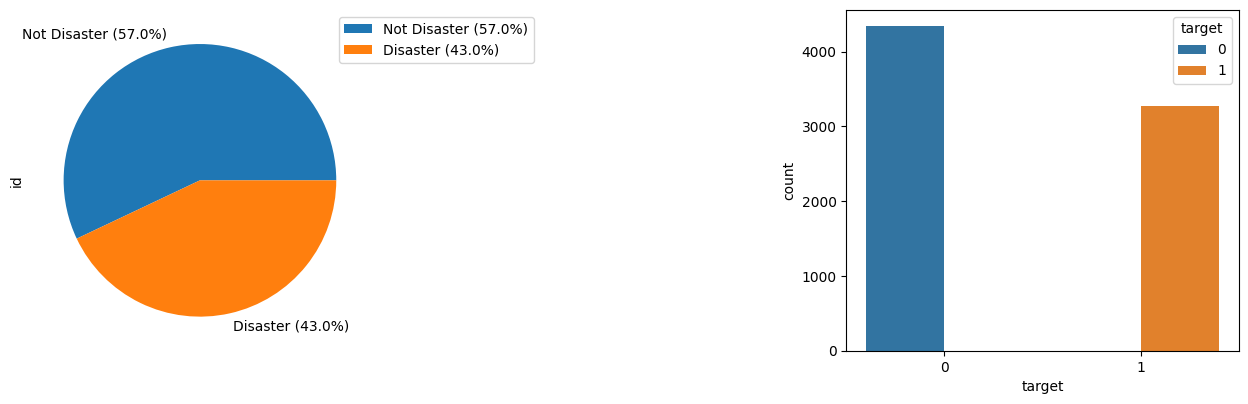

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100, gridspec_kw={'width_ratios': [3, 1]})
plt.tight_layout()
not_disaster_percent = (df_train.groupby('target').count()['id'] / df_train.count()['id'])[0]
disaster_percent = (df_train.groupby('target').count()['id'] / df_train.count()['id'])[1]
df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=[f'Not Disaster ({not_disaster_percent*100:.1f}%)', f'Disaster ({disaster_percent*100:.1f}%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1.))

plt.show()

In [5]:
df_train.groupby('target').count()['id'] / df_train.count()['id']

target
0    0.57034
1    0.42966
Name: id, dtype: float64

#NGrams

In [6]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

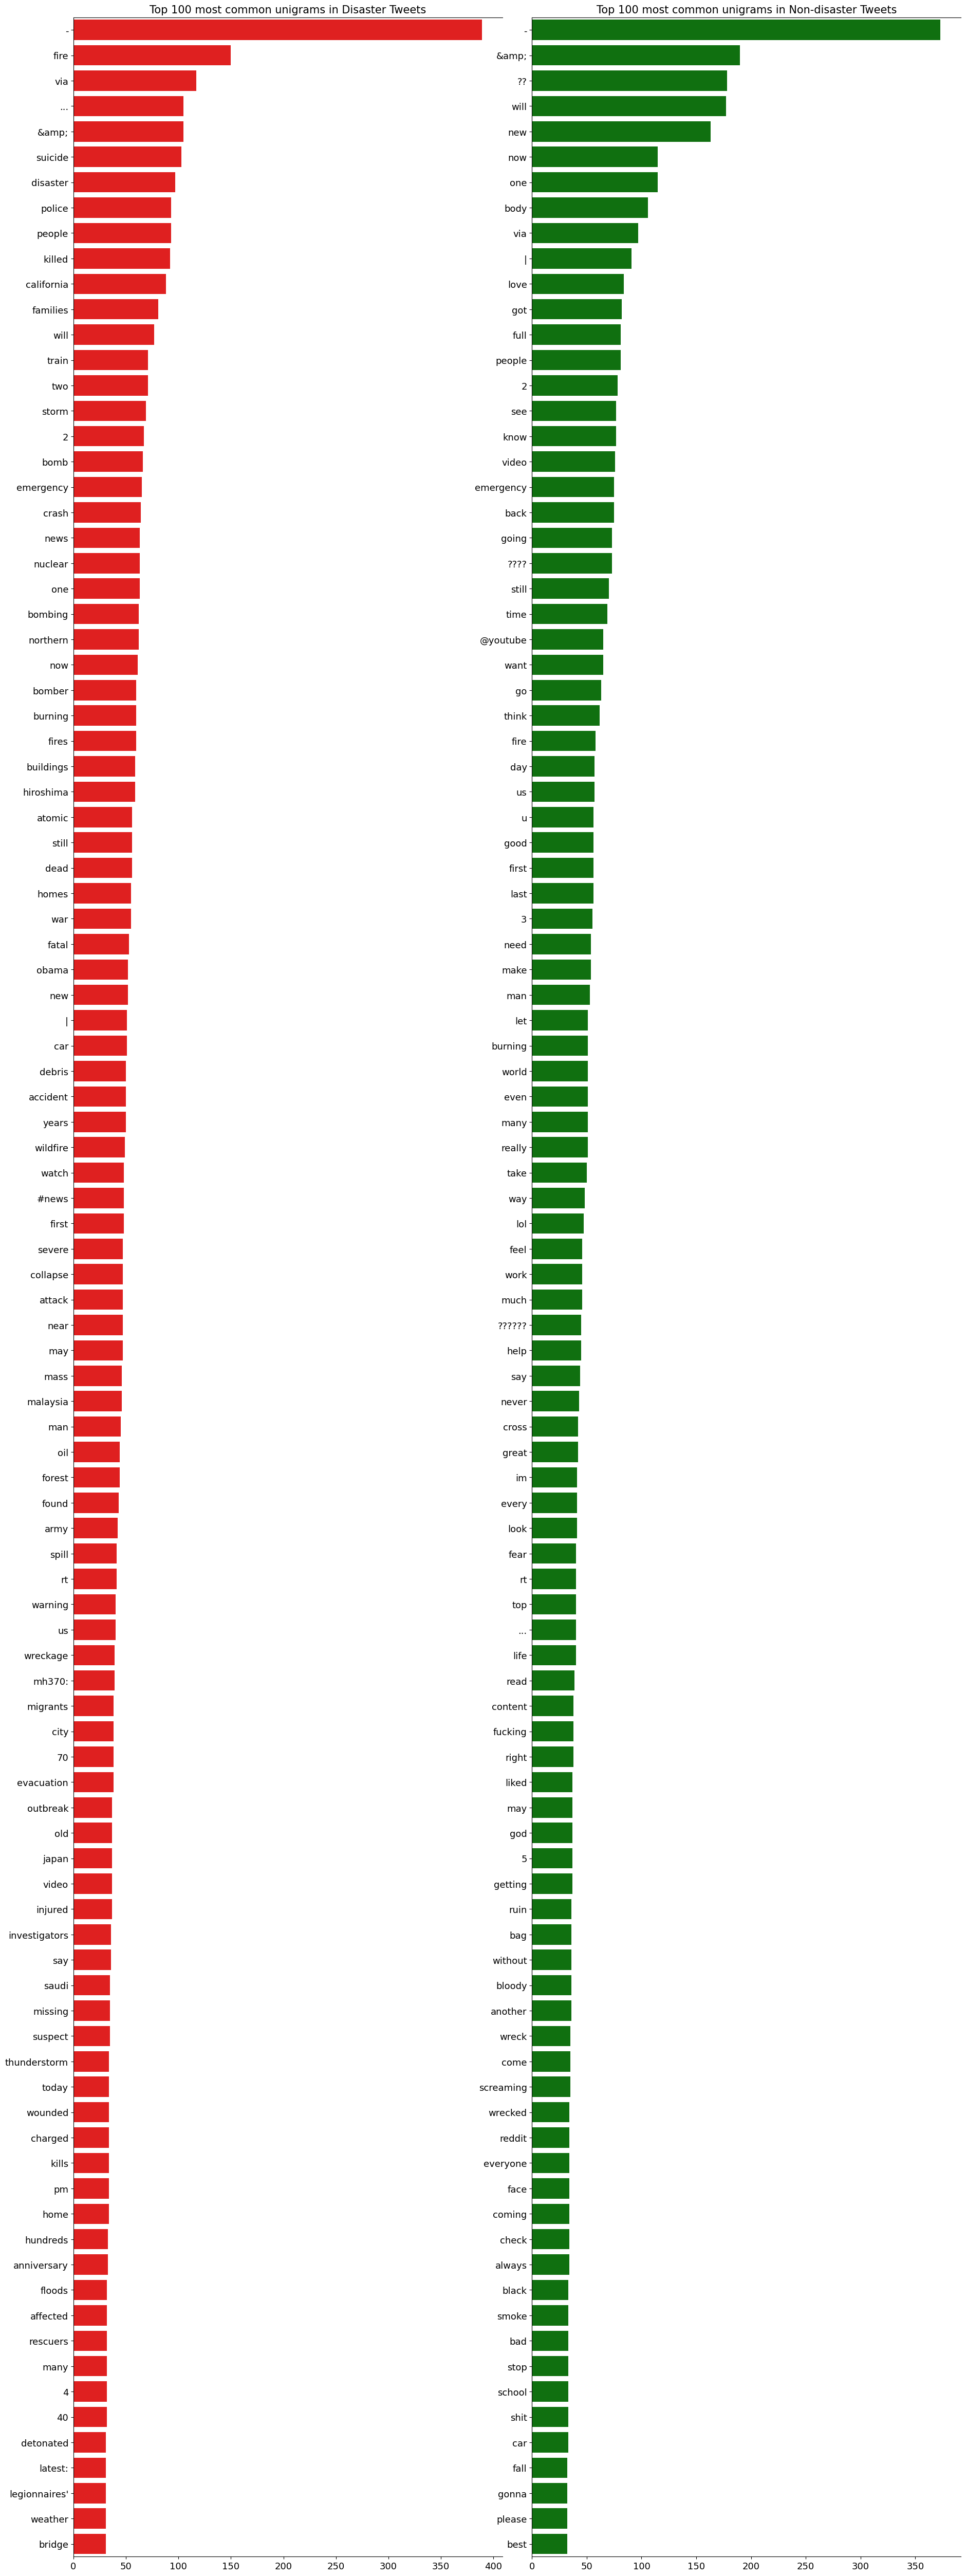

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## Common stopwords

<class 'tuple'>


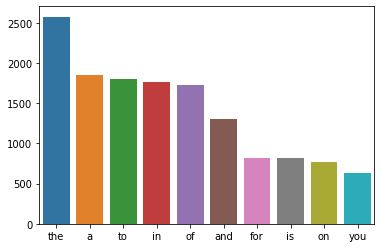

In [8]:
stopwords_dic = defaultdict(int)
for tweet in df_train['text']:
  for word in tweet.split():
    if word in STOPWORDS:
      stopwords_dic[word]+=1
stopwords_dic
top=sorted(stopwords_dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x, y = zip(*top)
print(type(x))
sns.barplot(x=list(x), y=list(y))

## Punctuations

<class 'tuple'>


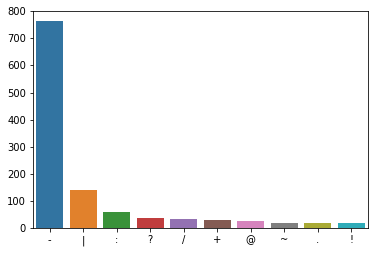

In [9]:
punctuations_dic = defaultdict(int)
for tweet in df_train['text']:
  for word in tweet.split():
    if word in string.punctuation:
      punctuations_dic[word]+=1
punctuations_dic
top=sorted(punctuations_dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x, y = zip(*top)
print(type(x))
sns.barplot(x=list(x), y=list(y))

## Most commons

[('the', 2575), ('I', 2394), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('The', 1104), ('for', 820), ('is', 814), ('on', 773), ('-', 763), ('you', 632), ('&amp;', 590), ('A', 580), ('my', 549), ('with', 508), ('that', 492), ('at', 485), ('by', 469), ("I'm", 450), ('it', 433), ('??', 428), ('will', 420), ('via', 416), ('from', 372), ('be', 371), ('was', 363), ('have', 353), ('are', 345), ('this', 335), ('like', 318), ('In', 310), ('fire', 296), ('...', 294), ('people', 292), ('2', 290), ('one', 284), ('as', 282), ('just', 258), ('your', 254), ('up', 250), ('but', 250), ('me', 244), ('so', 239), ('not', 236), ('has', 229), ('out', 226), ('This', 220), ('To', 216), ('new', 210), ('got', 206), ('after', 206), ('an', 204), ('now', 202), ('New', 196), ('????', 192), ('know', 192), ('about', 192), ('You', 192), ('My', 188), ('video', 186), ('been', 185), ('get', 183), ('going', 182), ('or', 181), ('when', 181), ('all', 178), ('California', 178), ('killed', 178), ('n

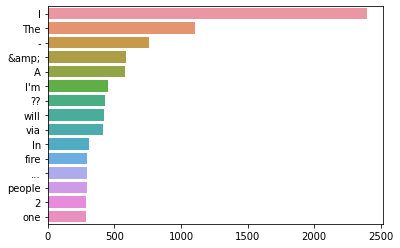

In [10]:
words = []
splitted_words = []
for tweet in df_train['text']:
    splitted_words = [word for word in tweet.split() if word not in STOPWORDS and word not in string.punctuation]
    words += splitted_words
    words += tweet.split()
counter=Counter(words)
most=counter.most_common()
print(most)
x=[]
y=[]
for word,count in most[:40]:
    if (word not in STOPWORDS) :
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x)
# sorted(most, key=lambda x:x[0])
# most[1]

#Data Cleaning

In [11]:
df = pd.concat([df_train, df_test])
df.shape

(10876, 14)

##removing links

In [12]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_URL(x))

##removing html tags

In [13]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

##removing emojis

In [14]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_emoji(x))

In [15]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected = spell.correction(word)
            if corrected is not None:
                corrected_text.append(corrected)
        else:
            corrected_text.append(word)
    
    return " ".join(corrected_text)

        
text = "corect me please"
correct_spellings(text)

'correct me please'

In [16]:
!pip install autocorrect
from autocorrect import Speller

spell = Speller(lang='en')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 622 kB 5.7 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=37813735221ed1f38e7b1da8e3a18cc7a7b2d0a9e58d78efcc2699e8106e8d6f
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect


In [17]:
# df['text']=df['text'].apply(lambda x : correct_spellings(x))


In [18]:
df.iloc[0:1]['text']

0    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Name: text, dtype: object

In [19]:
# %timeit df['text'][0:20].apply(lambda x : correct_spellings(x))

#Create Corpus

In [24]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in STOPWORDS))]
        corpus.append(words)
    return corpus
        

In [29]:
corpus=create_corpus(df)

100%|██████████| 3263/3263 [00:03<00:00, 1073.81it/s]


In [30]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-09-14 21:57:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-14 21:57:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-14 21:57:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [31]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [33]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [34]:
MAX_LEN=50

word_tokenize.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
from keras.preprocessing.sequence import pad_sequences
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

TypeError: ignored